# Force fields

In electronic structure theory, the [Born-Oppenheimer](https://en.wikipedia.org/wiki/Born%E2%80%93Oppenheimer_approximation) approximation is utilized to separate the Schrödinger equation into electronic and nuclear parts that can be solved separately. The electrons are approximated as responding instantly to any changes in the nuclear coordinates, allowing the electronic distribution to be found around stationary nuclei, after which the problem is solved for the nuclei moving in the effective potential generated by the electrons. [Molecular mechanics (MM)](https://en.wikipedia.org/wiki/Molecular_mechanics) takes this one step further and combines nuclei and electrons into a single unit, unsurprisingly referred to as atoms. 

The potential energy of the molecular system is determined from the atomic coordinates, using a [force field](https://kthpanor.github.io/echem/docs/mol_struct/forcefields.html) to describe the energy associated with changes in bond configurations, Coulombic interactions, dispersion, and more. A simple energy function can look like

\begin{align*}
 E &= E_{\mathrm{bond}} +E_{\mathrm{angle}} +E_{\mathrm{dihedral}} +E_{\mathrm{vdW}} + E_{\mathrm{electrostatic}} \\ &= E_{\mathrm{bonded}} + E_{\mathrm{nonbonded}},
\end{align*}

where we make a general distinction between terms associated with atoms bonded to each other, and those that are not. The force field is used to calculate the forces acting on each atom, model the dynamics of the system, and produce trajectories.

The included interactions and the functional form that they take can differ depending on the requirements of the force field, with some focused on describing specific groups of molecules well and some sacrificing accuracy for computational efficiency. Furthermore, the potential energy function of the system has as its variables the atomic coordinates, but it also depends parametrically on how the atoms are bonded and the types of the involved atoms. Creating accurate parameters can be a difficult and time-consuming process, with fittings made either to experimental data or higher level quantum mechanical calculations. A larger number of atom types makes it possible to give a more nuanced description of the interactions in the system, but it also strips away the transferability advantages. With more atom types the number of parameters quickly increases, and with them the likelihood that some of them will have to be created when studying a new system. 


We will now consider the construction of force fields, using simple functional forms (primarily harmonic functions), and optimize functional parameter by fitting to quantum mechanical results. Focus will be on ethane, with equilibrium structure and SCF:

In [13]:
import numpy as np
import py3Dmol as p3d
import veloxchem as vlx
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

# Bonded terms

The bonded interactions are relatively fast to evaluate, as they are local interactions and thus only affect a few atoms. The main bonded terms include bond stretch, angle bending, and dihedral angle bending, but more complex force field forms are also used. This include cross-terms, which can account for more complicated couplings between atoms, improper torsion, and more.


## Bond stretching

Stretching or contracting a bond from its equilibrium position causes the energy of the system to rise.


```{figure} ../../img/md/MM_stretch.svg
---
width: 300px
name: fig_bondstretch
---
Bond stretching.
```

This change in energy is approximated by the bond stretch terms, usually represented by a simple harmonic oscillator of the form

(eq:bond_stretch_harm)=
$$
{E_\mathrm{s}} = \frac{k_\text{s}}{2} (l - l_0)^2
$$

Where $l$ is the bond distance, $l_0$ the equilibrium length, and $k_l$ a force constant. Note that both $l_0$ and $k_l$ are constants specific to the combination of atom types involved in the interaction, and that $l_0$ is the distance that minimize the full potential (so not necessarily the molecular equilibrium distance). This harmonic form is incapable of considering bond breaking, and it is only approximately correct for relatively small distortions, but it is often sufficiently accurate for practical calculations.

We will now calculate the B3LYP potential energy surface of CO, and see how different fitted force fields can replicate the reference potential.


```{note}
We will here consider a larger bond distance, in order to more clearly see how different choices of force field fittings affect the general shape of the resulting potential. For practical studies, these large distortions of the CO bond will not be sampled, as 10 kJ/mol corresponds to a temperatuer of about 1200 K. Any regions of the PES above this will thus hardly be sampled for most simulations.
```

```python
co_base = """
O       0.0       0.0       0.0
C         x       0.0       0.0
"""

bond_e = []
bond_l = np.arange(1.05, 1.30, 0.01)

bond_xyz = ""
for l in bond_l:
    # Change C position
    co_tmp = co_base.replace("x", "{}".format(l))
    mol_vlx = vlx.Molecule.read_molecule_string(co_tmp)
    bas_vlx = vlx.MolecularBasis.read(mol_vlx, "6-31G")

    # Calculate B3LYP energy
    scf_drv = vlx.ScfRestrictedDriver()
    scf_drv.xcfun = "b3lyp"
    scf_results = scf_drv.compute(mol_vlx, bas_vlx)
    bond_e.append(scf_drv.get_scf_energy())
    bond_xyz += mol_vlx.get_xyz_string()

# index for minimal energy
bond_indx = bond_e.index(min(bond_e))

# Convert to kJ/mol and calculate the relative energy
bond_e = 2600.0 * (np.array(bond_e) - min(bond_e))
```

In [2]:
bond_e = np.array([75.11703695, 60.10065787, 47.05867392, 35.86484395, 26.40070754,
       18.5547992 , 12.22189548,  7.30321576,  3.70606838,  1.34342595,
        0.13362954,  0.        ,  0.87040529,  2.67655181,  5.35342884,
        8.83927786, 13.07568488, 18.00770938, 23.58391549, 29.75631048,
       36.47995008, 43.71253393, 51.41454046, 59.54913627, 68.08174504])
bond_l = np.array([1.05, 1.06, 1.07, 1.08, 1.09, 1.1 , 1.11, 1.12, 1.13, 1.14, 1.15,
       1.16, 1.17, 1.18, 1.19, 1.2 , 1.21, 1.22, 1.23, 1.24, 1.25, 1.26,
       1.27, 1.28, 1.29])
bond_indx = 11
bond_xyz = '2\n*\nO       0.0       0.0       0.0\nC         1.05       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.06       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.07       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.08       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.09       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.1       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.11       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.12       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.1300000000000001       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.1400000000000001       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.1500000000000001       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.1600000000000001       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.1700000000000002       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.1800000000000002       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.1900000000000002       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.2000000000000002       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.2100000000000002       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.2200000000000002       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.2300000000000002       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.2400000000000002       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.2500000000000002       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.2600000000000002       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.2700000000000002       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.2800000000000002       0.0       0.0\n2\n*\nO       0.0       0.0       0.0\nC         1.2900000000000003       0.0       0.0\n'

Structures and B3LYP potential energy surface:

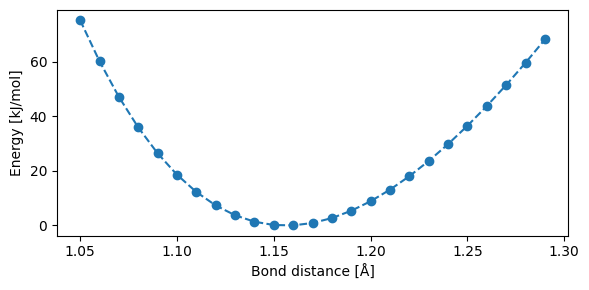

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [3]:
plt.figure(figsize=(6, 3))
plt.plot(bond_l, bond_e, "o--")
plt.xlabel("Bond distance [Å]")
plt.ylabel("Energy [kJ/mol]")
plt.tight_layout()
plt.show()

viewer = p3d.view(width=550, height=300)
viewer.setViewStyle({"style": "outline", "color": "black", "width": 0.1})
viewer.addModelsAsFrames(bond_xyz)
viewer.animate({"loop": "backAndForth"})
viewer.setStyle({"stick": {}, "sphere": {"scale": 0.25}})
viewer.show()

### Harmonic fit

This will now be fitted using the using three different approaches:

1. Using the full energy curve,
2. Using an interval symmetric around the minima in terms of **distance**,
3. Using an interval symmetric around the minima in terms of **energy**.

l_0 / k_s from fit #1: 1.167 / 9888.5
l_0 / k_s from fit #2: 1.157 / 10094.0
l_0 / k_s from fit #3: 1.158 Å / 10536.4 kJ/mol/Å
B3LYP bond distance: 1.160 Å


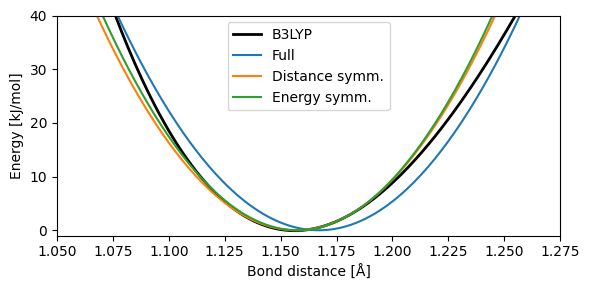

In [4]:
# function to be fitted to
def harm_func(l, l0, ks):
    return (ks / 2.0) * (l - l0) ** 2


# Feed with equilibrium distance and a stiff force constant
# Fit the full curve
opt_harm1 = curve_fit(harm_func, bond_l, bond_e, [bond_l[bond_indx], 1000])
print(
    "l_0 / k_s from fit #1: {:04.3f} / {:06.1f}".format(
        opt_harm1[0][0], opt_harm1[0][1]
    )
)

# fitting for minima +/-0.025 Å
for i in np.arange(len(bond_l)):
    if bond_l[i] < bond_l[bond_indx] - 0.025:
        i_min_d = i
    if bond_l[i] < bond_l[bond_indx] + 0.025:
        i_max_d = i + 1
opt_harm2 = curve_fit(
    harm_func,
    bond_l[i_min_d:i_max_d],
    bond_e[i_min_d:i_max_d],
    [bond_l[bond_indx], 1000],
)
print(
    "l_0 / k_s from fit #2: {:04.3f} / {:06.1f}".format(
        opt_harm2[0][0], opt_harm2[0][1]
    )
)

# Fit around the minimum +10 kJ/mol
for i in np.arange(len(bond_e)):
    if (bond_e[i] > 10.0) and (i < bond_indx):
        i_min_e = i
    if (bond_e[i] < 10.0) and (i > bond_indx):
        i_max_e = i
opt_harm3 = curve_fit(
    harm_func,
    bond_l[i_min_e:i_max_e],
    bond_e[i_min_e:i_max_e],
    [bond_l[bond_indx], 1000],
)
print(
    "l_0 / k_s from fit #3: {:04.3f} Å / {:06.1f} kJ/mol/Å".format(
        opt_harm3[0][0], opt_harm3[0][1]
    )
)
print("B3LYP bond distance: {:04.3f} Å".format(bond_l[bond_indx]))

plt.figure(figsize=(6,3))
x = np.arange(1.06, 1.29, 0.001)
y = interp1d(bond_l, bond_e, kind="cubic")
plt.plot(x, y(x), "k-", lw=2.0)  # splined B3LYP results
plt.plot(x, harm_func(x, opt_harm1[0][0], opt_harm1[0][1]))
plt.plot(x, harm_func(x, opt_harm2[0][0], opt_harm2[0][1]))
plt.plot(x, harm_func(x, opt_harm3[0][0], opt_harm3[0][1]))
plt.ylim(-1, 40)
plt.xlim((1.05, 1.275))
plt.legend(("B3LYP", "Full", "Distance symm.", "Energy symm."))
plt.xlabel("Bond distance [Å]")
plt.ylabel("Energy [kJ/mol]")
plt.tight_layout()
plt.show()

It is clear that using the full SCF curve we calculated yield unrealistic fits, as it puts weight on parts of the PES that will no be sampled by most dynamics. Using fits with intervals symmetric in either energy or bond distance yield similar results, especially within the region of most interest ($<10$ kJ/mol).

### Anharmonic fit

Generally, contracting a bond produces a steeper rise in energy than stretching it. This is accounted for in some force fields, for example by introducing anharmonicity into the bond energy expression by including higher order terms based on the [Morse potential](https://en.wikipedia.org/wiki/Morse_potential), which takes the form.

$$
V_{\mathrm{Morse}}(r) = D_e \left( 1 - e^{-\alpha (r -r_0)^2} \right)
$$

Where $D_e$ is the depth of the potential well, $\alpha$ the width, and $r_0$ the location of the minima. This form provides an improved description, in particular over larger bond deviations in which anharmonicity becomes substantial.   


## Angle bending

Distorting an angle formed between two atoms bound to a common third atom from its equilibrium also causes the energy of the system to rise:

```{figure} ../../img/md/MM_bend.svg
---
width: 300px
name: fig_MM_bend
---
Angle bending.
```

This can again be most easily be described by a harmonic function:

$$
E_{\theta} = \frac{k_{\theta}}{2} \left( \theta - \theta_0 \right)^2
$$

Here $\theta$ is the bond angle, $\theta_0$ the equilibrium bond angle, and $k_{\theta}$ a force constant. This form is again overly simplistic for large distortions, but sufficiently good for many practical considerations.


Scanning over bond lengths and angles are then achieved by introducing constraints in geometry optimizations, in order to get structures and energies along the scans. We here perform the fitting for the bond angle of water. As a scan creates output files which are then to be read, we instead "scan" one angle at a time and save the results. Constraining an angle is done with `opt_drv.constraints = ["scan angle 2 1 3 60 180 24"]`.

> Here the angle is defined by three atom indices (2, 1, and 3). Then, we need to specify the starting angle (60 deg), the final angle (180 deg) and the total number of angles we would like to scan over (24). 

> *Note:* Running this notebook will produce a number of temporary `.hd5`, `.pdb`, `.xyz`, and `.txt` files. They contain information on optimization settings, iterations, and more, and can safely be discarded.

In [5]:
# Set up the molecule and basis set
water_mol_str = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""

# Create veloxchem mol and basis objects
mol_vlx = vlx.Molecule.read_molecule_string(water_mol_str)
bas_vlx = vlx.MolecularBasis.read(mol_vlx, "6-31G")

scf_drv = vlx.ScfRestrictedDriver()
scf_drv.xcfun = "b3lyp"
scf_results = scf_drv.compute(mol_vlx, bas_vlx)

# Set up the gradient and optimization dirvers:
grad_drv = vlx.ScfGradientDriver(scf_drv)
opt_drv = vlx.OptimizationDriver(grad_drv)

# Define the constraints: scan angle atom1 atom2 atom3 
# start_angle stop_angle number_of_angles
opt_drv.constraints = ["scan angle 2 1 3 60 180 24"]

* Info * Reading basis set from file: /home/emi/miniconda3/envs/echem/lib/python3.11/site-packages/veloxchem/basis/6-31G  
                                                                                                                          
                                              Molecular Basis (Atomic Basis)                                              
                                                                                                                          
                               Basis: 6-31G                                                                               
                                                                                                                          
                               Atom Contracted GTOs           Primitive GTOs                                              
                                                                                                                          
                

```python
# Run the scan and save the results
opt_results = opt_drv.compute(mol_vlx, bas_vlx)
```

```python
scan_energies = opt_results['scan_energies']
scan_geometries = opt_results['scan_geometries']

# Transform to kJ/mol and calculte the relative energy
angle_e = 2600 * ( scan_energies - np.min(scan_energies) )

angle_a = np.arange(60, 180, 5)
```

In [6]:
import pickle
with open("angle_scan_geometries.pkl", 'rb') as f:
    scan_geometries = pickle.load(f)

In [7]:
angle_a = np.arange(60, 180, 5)
angle_e = np.array([172.03894697, 137.45086426, 106.68236192,  79.79080496,
        56.83083193,  37.85283667,  22.8400084 ,  11.71294445,
         4.33930422,   0.51932171,   0.        ,   2.48393072,
         7.60038175,  14.9386996 ,  24.0475298 ,  34.42068994,
        45.50438087,  56.75846138,  67.66668566,  77.75405949,
        86.58281485,  93.78798178,  99.11273686, 102.3905425 ])

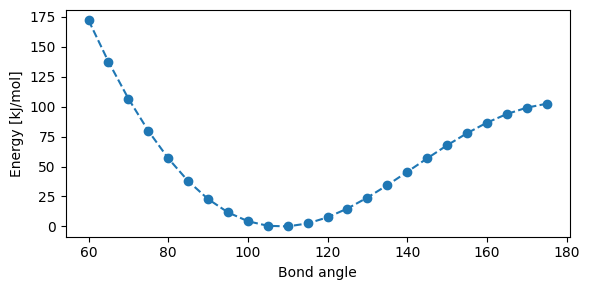

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [8]:
plt.figure(figsize=(6, 3))
plt.plot(angle_a, angle_e, "o--")
plt.xlabel("Bond angle")
plt.ylabel("Energy [kJ/mol]")
plt.tight_layout()
plt.show()

def vlx2py3d(geometries):
    """ Converts the array of xyz coordinates from a scan to
        a string which can be read py py3Dmol.

        :param geometries: the scan geometries.
    """
    txt = ""
    for geometry in geometries:
        txt += geometry
    return txt

structure = vlx2py3d(scan_geometries)
viewer = p3d.view(width=550, height=300)
viewer.setViewStyle({"style": "outline", "color": "black", "width": 0.1})
viewer.addModelsAsFrames(structure)
viewer.animate({"loop": "backAndFirth"})
viewer.setStyle({"stick": {}, "sphere": {"scale": 0.25}})
viewer.rotate(-90, "x")
viewer.show()

### Harmonic fit

Now we will fit the potential energy curve using a a harmonic function and focusing on an interval with equal energy end-points:

l_0 / k_s from fit: 108.814 / 0.126546
B3LYP angle: 110.0


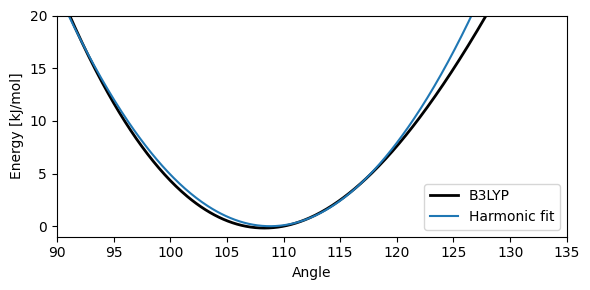

In [9]:
angle_indx = 10

# Fit around the minimum +20 kJ/mol
for i in np.arange(len(angle_e)):
    if (angle_e[i] > 20.0) and (i < angle_indx):
        i_min_a = i
    if (angle_e[i] < 20.0) and (i > angle_indx):
        i_max_a = i
opt_harm_angle = curve_fit(
    harm_func, angle_a[i_min_a:i_max_a], angle_e[i_min_a:i_max_a]
)
print(
    "l_0 / k_s from fit: {:04.3f} / {:7f}".format(
        opt_harm_angle[0][0], opt_harm_angle[0][1]
    )
)
print("B3LYP angle: {:04.1f}".format(angle_a[angle_indx]))

plt.figure(figsize=(6, 3))
x = np.arange(75, 150, 0.1)
y = interp1d(angle_a, angle_e, kind="cubic")
plt.plot(x, y(x), "k-", lw=2.0)  # Plot spline B3LYP results
plt.plot(x, harm_func(x, opt_harm_angle[0][0], opt_harm_angle[0][1]))
plt.ylim(-1, 20)
plt.xlim((90, 135))
plt.legend(("B3LYP", "Harmonic fit"))
plt.xlabel("Angle")
plt.ylabel("Energy [kJ/mol]")
plt.tight_layout()
plt.show()

The real angle bending interaction is clearly not a harmonic oscillator, as exemplified by the potential energy curve in below Figure, showing the change in energy when distorting the H-O-H angle found in water. Compressing the angle causes the two hydrogen atoms to come close together, leading to a steep curve near $\theta = 0^\circ$, while increasing the angle leads to a cusp at $\theta = 180^\circ$ due to symmetry. Again, some force fields account for this anharmonicity with additional terms, such as the angle bending term:

\begin{equation*}
\begin{split}
{E_\theta} = \frac{k_\theta}{2} (\theta - \theta_0)^2 \bigl( 1 &- \alpha (\theta - \theta_0) + \beta (\theta - \theta_0)^2  \\
 & - \gamma (\theta - \theta_0)^3 + \delta (\theta - \theta_0)^4 \bigr)
\end{split}
\end{equation*} 

where the constants have been fitted to experimental data but are the same for all bending interactions. This gives a better agreement with the actual angle bending behaviour, but again, for lower temperatures the harmonic oscillator is still a valid and computationally efficient approximation. 


## Torsion

When two atoms are bonded to atoms on opposite sides of a central bond, as for the opposing hydrogen atoms in ethane, then twisting these around the central bond can cause a change in the potential energy. The torsional energy is thus a function of the dihedral angle, $\omega$, formed between the first and fourth atom, while looking through the bond between the second and third atoms:


```{figure} ../../img/md/MM_torsion.svg
---
width: 300px
name: fig_MM_torsion
---
Torsion.
```

The torsion energy term is usually expressed in terms of a Fourier expansion of the form

$$
{E_\omega} = k_\omega \left(1 + \cos(n\omega -\delta)\right)
$$

where $k_\omega$ is a force constant, $n$ is the periodicity and $\delta$ is a phase shift. Typically, several such terms are included for each set of four atoms in order to combine different multiplicities. The MM3 force field always includes terms of multiplicity 1, 2 and 3, with $\delta$ set to zero for each, while the CHARMM force field allows a more varied combination of terms.

It should be noted that the torsional energy of the force field does not come from a single interaction in this case, but several. It is easy to see that torsional interactions can quickly become very complicated when there are many atom types involved. This is further complicated by the fact that most force field also include non-bonded interactions between atoms separated by more than two bonds, meaning that the true rotational barrier will be a sum of all torsional and non-bonded interactions. For calculations where both the conformations themselves as well as the transitions between them are important, it is necessary to recreate the full potential energy curve and not just focus on the regions around the minima, as was done for bond stretching and angle bending terms. 

In [10]:
# Set up the molecule and basis set
ethane_mol_str = """
C       0.0000000000     0.0000000000     0.7616375820
C       0.0000000000     0.0000000000    -0.7616375820
H       1.0145603421     0.0000000000     1.1557300969
H      -0.5072801711    -0.8786350299     1.1557300969
H      -0.5072801711     0.8786350299     1.1557300969
H       0.5072801711    -0.8786350299    -1.1557300969
H       0.5072801711     0.8786350299    -1.1557300969
H      -1.0145603421    -0.0000000000    -1.1557300969
"""

# Create veloxchem mol and basis objects
mol_vlx = vlx.Molecule.read_molecule_string(ethane_mol_str)
bas_vlx = vlx.MolecularBasis.read(mol_vlx, "STO-3G")

scf_drv = vlx.ScfRestrictedDriver()
scf_results = scf_drv.compute(mol_vlx, bas_vlx)

# Set up the gradient and optimization dirvers:
grad_drv = vlx.ScfGradientDriver(scf_drv)
opt_drv = vlx.OptimizationDriver(grad_drv)

# Set up the constraints: scan dihedral atom1 atom2 atom3 atom4
# start_dihedral stop_dihedral number_of_dihedrals
opt_drv.constraints = ["scan dihedral 3 1 2 6 0 60 13"]

* Info * Reading basis set from file: /home/emi/miniconda3/envs/echem/lib/python3.11/site-packages/veloxchem/basis/STO-3G 
                                                                                                                          
                                              Molecular Basis (Atomic Basis)                                              
                                                                                                                          
                               Basis: STO-3G                                                                              
                                                                                                                          
                               Atom Contracted GTOs           Primitive GTOs                                              
                                                                                                                          
                

```python
# Run the scan
opt_results = opt_drv.compute(mol_vlx, bas_vlx)
scan_energies = opt_results['scan_energies']
scan_geometries = opt_results['scan_geometries']
dihed_e = 2600 * ( scan_energies - np.min(scan_energies) )
dihed_a = np.arange(0, 65, 5)
```

In [11]:
dihed_a = np.arange(0, 65, 5)
dihed_e = np.array([11.42688953, 11.21724467,10.60722575,
       9.64639677,  8.41325502,  
        7.00143352,  5.51353275,  4.05098902,
        2.71183578,  1.57755804,  
        0.71808092,  0.18165335,  0.        ])
with open("dihedral_scan_geometries.pkl", 'rb') as f:
    scan_geometries = pickle.load(f)

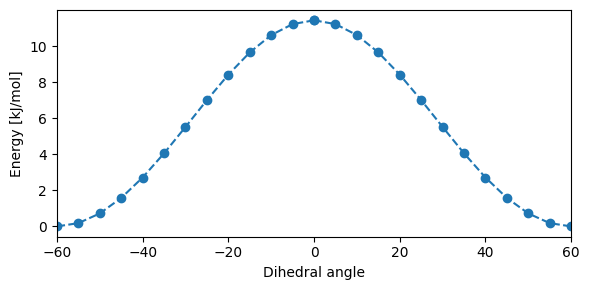

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [12]:
plt.figure(figsize=(6, 3))
plt.plot(dihed_a, dihed_e, "o--", color="#1f77b4")
plt.plot(-dihed_a, dihed_e, "o--", color="#1f77b4")
plt.xlabel("Dihedral angle")
plt.ylabel("Energy [kJ/mol]")
plt.xlim((-60, 60))
plt.tight_layout()
plt.show()

structure = vlx2py3d(scan_geometries)
viewer = p3d.view(width=600, height=300)
viewer.setViewStyle({"style": "outline", "color": "black", "width": 0.1})
viewer.addModelsAsFrames(structure)
viewer.animate({"loop": "backAndForth"})
viewer.setStyle({"stick": {}, "sphere": {"scale": 0.25}})
viewer.rotate(25, "x")
viewer.rotate(25, "y")
viewer.show()

# Non-bonded terms

The non-bonding terms include electrostatic interaction and van der Waals dispersion, resulting from charge distributions in the molecules and induced dipole-dipole interactions, respectively. As these interactions couple all atoms in the molecule, the evaluation of these terms can easily be the most costly part of an MD simulation, leading to a cut-off radius being applied for many cases. Note that atoms connected by chemical bonds are normally excluded from non-bonded terms, with the bonded terms accounting for these interactions.


## van der Waals interactions

The van der Waals interactions can be  modeled using a Lennard-Jones potential:

$$
{E_\mathrm{LJ}} = 4\epsilon \left[ \left( \frac{\sigma}{r} \right)^{12} - \left( \frac{\sigma}{r} \right)^6 \right].
$$

The first ($r^{-12}$) term is due to exchange interaction, resulting in strong repulsion at short distances, and the second ($r^{-6}$) is due to induced dipole-dipole interactions, causing a weak attraction at longer distances. Of these, the second term has the correct physical scaling with distances, but the exchange interaction is only approximately correct, being too steep at short distances. More advanced force field forms are thus available, but Lennard-Jones is often used on account of its low computational cost, coupled with reasonable accuracy.



## Electrostatic interaction

Electrostatic interactions can be calculated using Coulomb's law:

$$
{E_\mathrm{electrostatic}} = \frac{q_i q_j}{4\pi \epsilon_0 r_{ij}},
$$

with $q_i$ and $q_j$ being point charges representing the (partial) charges of the interacting atoms. Again, more advanced interactions can be included for increasing accuracy. Many different approaches for estimating atomic charges are used, and we favour the restrained electrostatic potential ([RESP](https://kthpanor.github.io/echem/docs/env/resp.html)) charge model. It is also possible to use higher order multipoles, where dipole moments are assigned to each bonded pair. This gives the advantage of a more flexible description, as the dipoles depend on the types of both involved atoms, but requires additional parametrization and has difficulty dealing with ionic systems.

## Van der Waals interaction

The van der Waals interaction is typically represented by two terms. One due to exchange interaction, causing a strong repulsion at close distances, and one that is due to London dispersion, resulting in a weak attraction at longer distances. The most commonly used form is the [Lennard-Jones potential]:

$$
{E_\mathrm{vdw}} = \epsilon \left[ \left( \frac{r_\text{min}}{r} \right)^{12} - 2 \left( \frac{r_\text{min}}{r} \right)^6 \right]
$$

\noindent where $\epsilon$ is the depth of the potential well, usually created as the mean of two parameters specific to the two interacting atom types, $r_\text{min}$ is the position of the bottom of the well and $r$ is the interatomic distance. While it is possible to motivate the use of $r^{-6}$ for the attractive part, the use of $r^{-12}$ for the repulsive part is more pragmatic in origin, having that form simply because it is the square of $r^{-6}$, making its computation highly efficient.


## Additional terms
Depending on what the force field is intended for, many additional terms can be added to the potential energy function. Cross-terms are a common addition, accounting for more complex couplings between structural properties. Examples of these include stretch--bend, torsion--stretch and bend--bend interactions. As an example, the stretch--bend interaction accounts for the fact that compressing an angle formed by three bonded atoms will cause the repulsion between the two end atoms to increase, resulting in an elongation of their bonds to the middle atom. Another example of such structural corrections comes in the form of the out-of-plane term. If three or four atoms are bonded to a central atom with their equilibrium position in a plane, as for *e.g.* formaledehyde, the change in energy caused by a distortion of the central atom out of the plane is hard to model by just angle bending terms, as the individual angle distortions are small. The out-of-plane term instead depends on the angles formed between the plane and the bonds connecting the central and outer atoms. This is shown below, where the $\chi$ is an example of an out-of-plane angle. 


```{figure} ../../img/md/MM_outofplane.svg
---
width: 300px
name: fig_MM_outofplane
---
Out-of-plane bending.
```
